In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(threshold=np.inf)

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def ResnetBlock(input,filters,strides,residual_path):
    residual=input
    x=tf.keras.layers.Conv2D(filters=filters,kernel_size=(3,3),strides=strides,padding='same',use_bias=False)(input)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation('relu')(x)

    x=tf.keras.layers.Conv2D(filters=filters,kernel_size=(3,3),strides=1,padding='same',use_bias=False)(x)
    y=tf.keras.layers.BatchNormalization()(x)

    if residual_path:
        residual=tf.keras.layers.Conv2D(filters=filters,kernel_size=(1,1),strides=strides,padding='same',use_bias=False)(input)
        residual=tf.keras.layers.BatchNormalization()(residual)

    output=tf.keras.layers.Activation('relu')(y+residual)
    return output
        

In [7]:
def Resnet18(block_list,initial_filters):
    block_num=len(block_list)
    out_filters=initial_filters

    inputs=tf.keras.Input(shape=(None,None,3))
    x=tf.keras.layers.Conv2D(filters=out_filters,kernel_size=(3,3),strides=1,padding='same',use_bias=False,kernel_initializer='he_normal')(inputs)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation('relu')(x)

    for block_id in range(block_num):
        for layer_id in range(block_list[block_id]):
            if block_id!=0 and layer_id==0:
                x=ResnetBlock(x,filters=out_filters,strides=2,residual_path=True)
            else:
                x=ResnetBlock(x,filters=out_filters,strides=1,residual_path=False)
        out_filters*=2

    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    output=tf.keras.layers.Dense(10,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2())(x)
    model=tf.keras.Model(inputs,output)
    return model

In [8]:
model = Resnet18(block_list=[2,2,2,2],initial_filters=64)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/Baseline.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

Epoch 1/5
782/782 [==============================] - 30s 38ms/step - loss: 1.3748 - sparse_categorical_accuracy: 0.5594 - val_loss: 1.5584 - val_sparse_categorical_accuracy: 0.5700
Epoch 2/5
782/782 [==============================] - 29s 37ms/step - loss: 0.8016 - sparse_categorical_accuracy: 0.7436 - val_loss: 1.0098 - val_sparse_categorical_accuracy: 0.6808
Epoch 3/5
782/782 [==============================] - 29s 37ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.8074 - val_loss: 0.8277 - val_sparse_categorical_accuracy: 0.7398
Epoch 4/5
782/782 [==============================] - 29s 37ms/step - loss: 0.4625 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.7944 - val_sparse_categorical_accuracy: 0.7468
Epoch 5/5
782/782 [==============================] - 29s 37ms/step - loss: 0.3677 - sparse_categorical_accuracy: 0.8818 - val_loss: 0.8188 - val_sparse_categorical_accuracy: 0.7639
Model: "model_1"
______________________________________________________________________________

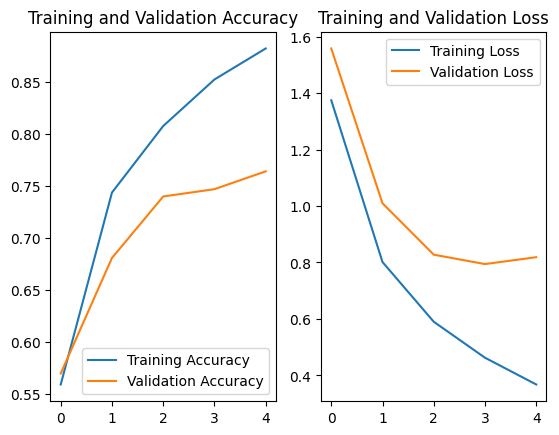

In [9]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()